# 8-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

라이브러리 버전을 확인해 봅니다

사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import pandas
import konlpy
import gensim
import tensorflow as tf
import os 
print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


# 1) 데이터 준비와 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2) 데이터로더 구성

실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 

그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 

이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. 

data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화 (tokenize)
- 불용어(Stopwords) 제거 (
- 사전word_to_index 구성 (단어를 index로)
- 텍스트 스트링을 사전 인덱스 스트링으로 변환 (embedding)
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
train_data[train_data['document'].isna()].index

Int64Index([25857, 55737, 110014, 126782, 140721], dtype='int64')

In [4]:
train_data = train_data.dropna()

결측값 제거

In [5]:
train_data[train_data['label'].isna()]

,id,document,label


In [6]:
train_data = train_data.drop_duplicates(['document','label'])

train_data의 중복값과 결측치를 제거한다.

In [7]:
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [8]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab() #한국어 토크나이저
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] #불용어 stopwords

#사전word_to_index 구성 (단어를 index로)
#텍스트 스트링을 사전 인덱스 스트링으로 변환 (embedding)
#X_train, y_train, X_test, y_test, word_to_index 리턴

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train=[]
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # temp_X에는 문장각 내용 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)
        
    X_test=[]
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
        
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    
    counter= counter.most_common(10000-4)
    vocab=['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['']for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])),word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [9]:
index_to_word = {index:word for word, index in word_to_index.items()}

X_train, X_test는 각 단어의 토큰 index가 저장된다.

y_train, y_test는 라벨값이다.


In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3) 모델 구성을 위한 데이터 분석 및 가공

데이터셋 내 문장 길이 분포

적절한 최대 문장 길이 지정

keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

num_tokens에 각 문장에 대해서 단어 갯수를 구한다. 그거의 np.array를 놓음 즉 문장길이 지정을 위해서 배열로 놓는다

In [11]:
total_data_text = list(X_train) + list(X_test)
num_tokens=[len(tokens) for tokens in total_data_text]
num_tokens= np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다.


In [12]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index[''],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index[''],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


# 4) 모델 구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [13]:
# 8-9
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8)) 
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 dim입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


# 5) 모델 훈련 개시


In [14]:
#validation 20000개
X_val = X_train[-20000:]
y_val = y_train[-20000:]

#validation set을 제외한 나머지 15000건
partial_X_train = X_train[:-20000]
partial_y_train = y_train[:-20000]

In [15]:
#model 학습을 시작해 봅시다.
model.compile(optimizer='adam',
              loss ='binary_crossentropy',
              metrics=(['accuracy'])
             )
epochs=20
history = model.fit(partial_X_train, partial_y_train,epochs=epochs,
          batch_size=512,
          validation_data=(X_val, y_val),
          verbose=1
         )


Epoch 1/20
247/247 [==============================] - 5s 7ms/step - loss: 0.5097 - accuracy: 0.7607 - val_loss: 0.3773 - val_accuracy: 0.8391
Epoch 2/20
247/247 [==============================] - 1s 6ms/step - loss: 0.3449 - accuracy: 0.8553 - val_loss: 0.3540 - val_accuracy: 0.8468
Epoch 3/20
247/247 [==============================] - 1s 6ms/step - loss: 0.3207 - accuracy: 0.8670 - val_loss: 0.3514 - val_accuracy: 0.8476
Epoch 4/20
247/247 [==============================] - 1s 6ms/step - loss: 0.3095 - accuracy: 0.8724 - val_loss: 0.3507 - val_accuracy: 0.8494
Epoch 5/20
247/247 [==============================] - 1s 6ms/step - loss: 0.3002 - accuracy: 0.8760 - val_loss: 0.3594 - val_accuracy: 0.8438
Epoch 6/20
247/247 [==============================] - 1s 6ms/step - loss: 0.2910 - accuracy: 0.8805 - val_loss: 0.3592 - val_accuracy: 0.8423
Epoch 7/20
247/247 [==============================] - 1s 6ms/step - loss: 0.2824 - accuracy: 0.8850 - val_loss: 0.3557 - val_accuracy: 0.8481
Epoch 

In [16]:
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4886 - accuracy: 0.8401
[0.4885745644569397, 0.8401041626930237]


# 6) Loss, Accuracy 그래프 시각화


In [17]:
#model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장되어 있습니다.
history_dict = history.history
print(history_dict.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


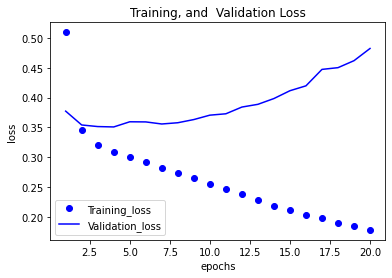

In [18]:
import matplotlib.pyplot as plt
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

# "bo"는 "파란색 점"입니다.
plt.plot(epochs, loss, 'bo', label='Training_loss')
# 'b'는 파란색 실선이다.
plt.plot(epochs, val_loss, 'b', label='Validation_loss')
plt.title('Training, and  Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


# 7) 학습된 Embedding 레이어 분석

In [19]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)



(10000, 16)


In [28]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/exploration/word2vec.txt'

f= open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) #몇개의 벡터를 얼마의 사이즈로 기재할지 

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [29]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

vector = word_vectors['사랑']
vector

array([ 0.20728523,  0.10288877,  0.0937077 , -0.14378497,  0.10947222,
        0.1259484 ,  0.09809761, -0.07850978, -0.13718002, -0.0623871 ,
       -0.21761651,  0.10238208, -0.15372705, -0.13577   , -0.1230868 ,
        0.10220447], dtype=float32)

'사랑'에 대한 wordvector

In [30]:
# 워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인하는 방법 중에, 
# 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법이 있습니다. gensim을 사용하면 아래와 같이 해볼 수 있습니다.
word_vectors.similar_by_word("사랑")

[('요괴', 0.9605420231819153),
 ('사라질', 0.9572589993476868),
 ('이소룡', 0.9546595215797424),
 ('판사', 0.9546411633491516),
 ('카이', 0.9539645314216614),
 ('여신', 0.9502131938934326),
 ('찌질이', 0.9496913552284241),
 ('일리', 0.949455976486206),
 ('짱', 0.9490277171134949),
 ('깊', 0.9487717151641846)]

'헉'에 대해서 유사도가 높은 순서대로 단어들을 출력해준다.

# 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [23]:
word2vec_file_path

'/aiffel/aiffel/exploration/word2vec.txt'

In [32]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = os.getenv("HOME")+'/data/word2vec_ko.model'
word_vectors2 = Word2VecKeyedVectors.load(word2vec_file_path)
#word_vectors2 = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000) #인코딩문제난다.
vector = word_vectors2.wv['사랑']
#vector2 = word_vectors['헉']

In [33]:
word_vectors #기존에 사용한 모델

In [34]:
word_vectors2 # word2vec 임베딩.. 

In [36]:
word_vectors2.wv.similar_by_word('사랑') #word_vectors.wv 가 keyedvectors가 되서 이걸로 쭉 사용하면 된다.

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

In [46]:
len(word_vectors2.wv[0])

100

In [47]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors2.wv:
        embedding_matrix[i] = word_vectors2.wv[index_to_word[i]]

In [95]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100   # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

model.add(tf.keras.layers.LSTM(41)) 
#model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
#model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
lstm_10 (LSTM)               (None, 41)                23288     
_________________________________________________________________
dense_38 (Dense)             (None, 16)                672       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 17        
Total params: 1,023,977
Trainable params: 1,023,977
Non-trainable params: 0
_________________________________________________________________


In [96]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 3s 8ms/step - loss: 0.5088 - accuracy: 0.7422 - val_loss: 0.4126 - val_accuracy: 0.8137
Epoch 2/10
247/247 [==============================] - 2s 7ms/step - loss: 0.3765 - accuracy: 0.8334 - val_loss: 0.3619 - val_accuracy: 0.8389
Epoch 3/10
247/247 [==============================] - 2s 7ms/step - loss: 0.3300 - accuracy: 0.8580 - val_loss: 0.3438 - val_accuracy: 0.8497
Epoch 4/10
247/247 [==============================] - 2s 6ms/step - loss: 0.3022 - accuracy: 0.8719 - val_loss: 0.3352 - val_accuracy: 0.8540
Epoch 5/10
247/247 [==============================] - 2s 6ms/step - loss: 0.2818 - accuracy: 0.8817 - val_loss: 0.3399 - val_accuracy: 0.8514
Epoch 6/10
247/247 [==============================] - 2s 6ms/step - loss: 0.2666 - accuracy: 0.8891 - val_loss: 0.3348 - val_accuracy: 0.8576
Epoch 7/10
247/247 [==============================] - 2s 6ms/step - loss: 0.2511 - accuracy: 0.8979 - val_loss: 0.3341 - val_accuracy: 0.8579
Epoch 

In [97]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3729 - accuracy: 0.8518
[0.37286147475242615, 0.8518217206001282]


회고

기존에 진행했던것은 영어였지만 이번에 우리가 진행해야하는 언어는 한국어였다.

이 과정에서 사용하는 토크나이저도 다르고, 임베딩레이어에 적용할 모델 또한 한국어를 위한 모델을 사용해야했다.

NLP쪽은 상당히 어려운내용인것 같다. 

gensim 유사단어 찾기 한것

1537/1537 - 3s - loss: 0.4886 - accuracy: 0.8401
[0.4885745644569397, 0.8401041626930237]

사전학습 임베딩

1537/1537 - 3s - loss: 0.5482 - accuracy: 0.8332
[0.5482152700424194, 0.8331875205039978]

으로 gensim 유사단어찾기가 더 정확하게 나왔다. 하지만 여기서 모델 하이퍼 파라미터 값을 수정해봐도 변하는 것이 없다.

85%넘는 방법이 있을거같은데 찾고있다.

--> LSTM을 사용, 41개의 unit으로 사용했다

word2vec를 활용해서 네이버 감정리뷰 정확도가 85이상으로 나왔다.

1537/1537 - 3s - loss: 0.3729 - accuracy: 0.8518
[0.37286147475242615, 0.8518217206001282]

